# Project 2

thoughts: using polar coordinates

In [2]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from scipy.signal import convolve2d


In [3]:
image_path = "assets/image.jpg"
raw_image = Image.open(image_path)

raw_image.size, raw_image.mode
# raw_image

((7525, 5729), 'RGB')

resized image size: (752, 572)


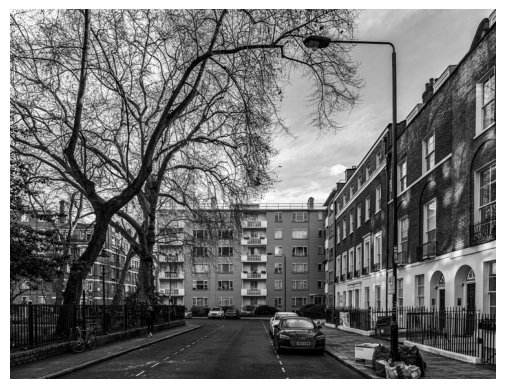

In [4]:
reduce_factor = 10

new_width = raw_image.width // reduce_factor
new_height = raw_image.height // reduce_factor

# Resize image using ANTIALIAS for better quality
resized_image = raw_image.resize((new_width, new_height), Image.LANCZOS)
print("resized image size:", resized_image.size)
image = resized_image.convert("L")
image_array = np.array(image, dtype=np.float32)
image_array /= 255.0 # Normalize to [0, 1]
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.show()

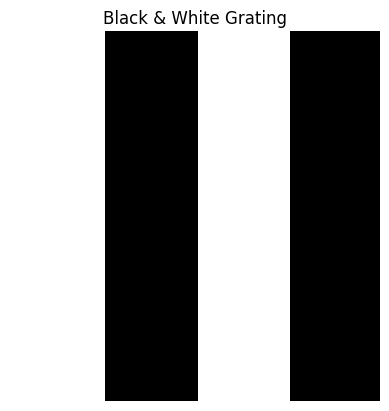

In [50]:
def create_grating(shape=(256, 256), period=50, phase=0, rotation=0):
    height, width = shape
    # Create a coordinate grid
    y, x = np.indices((height, width))
    
    # Convert phase and rotation from degrees to radians
    phase_rad = np.deg2rad(phase)
    theta = np.deg2rad(rotation)
    
    # Rotate the x-coordinates by theta
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    
    # Generate the sinusoidal grating pattern
    grating = np.sin((2 * np.pi / period) * x_rot + phase_rad)
    
    # Convert the sinusoidal pattern to binary
    pattern = (grating >= 0).astype(np.float32)
    return pattern

grating_array = create_grating(shape=(128, 128), period=64, phase=0, rotation=0)

plt.imshow(grating_array, cmap='gray', interpolation='nearest')
plt.title('Black & White Grating')
plt.axis('off')
plt.show()

## Gabor Function

$$
D_s(x, y) = \frac{1}{2\pi\sigma_x\sigma_y} \exp\left( -\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2} \right) \cos(kx - \phi).
$$

The parameters in this function determine the properties of the spatial receptive field: 
$\sigma_x$ and $\sigma_y$ determine its extent in the $x$ and $y$ directions, respectively;
$k$, the preferred spatial frequency, determines the spacing of light and dark bars that produce the maximum response 
(the preferred spatial wavelength is $2\pi/k$); and $\phi$ is the preferred spatial phase, which determines 
where the ON-OFF boundaries fall within the receptive field.


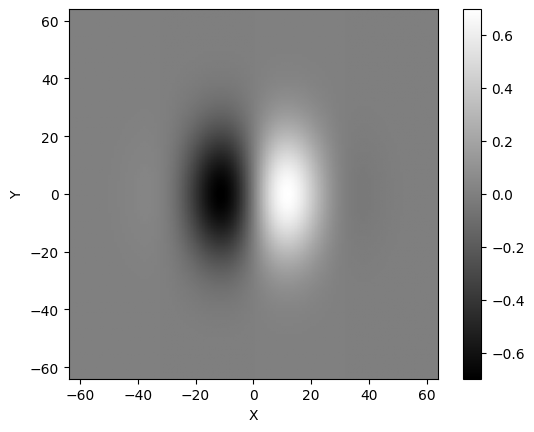

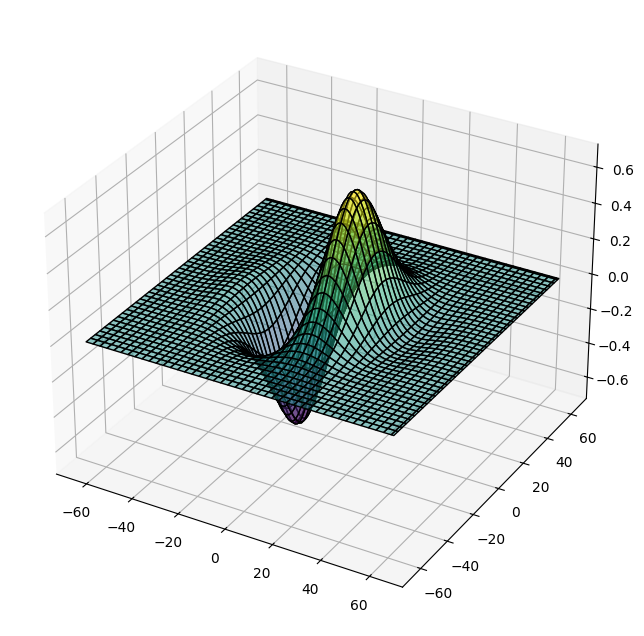

In [47]:
def gabor_function(x, y, wavelength, orientation, phase, sigma_x, sigma_y):
    # Rotate coordinates
    x_theta = x * np.cos(orientation) + y * np.sin(orientation)
    y_theta = -x * np.sin(orientation) + y * np.cos(orientation)
    # Gaussian Envelope
    gaussian_envelope = np.exp(-(x_theta**2 / (2 * sigma_x**2) + y_theta**2 / (2 * sigma_y**2)))
    # Sinusoidal plane wave
    sinusoid = np.cos(2 * np.pi * x_theta / wavelength + phase)
    return gaussian_envelope * sinusoid

neuron_size = 128 # wavelength of the Gabor filter
wavelength = neuron_size / 2
orientation = np.pi
phase = np.pi / 2
sigma_x = wavelength/4 # arbitrary choice
sigma_y = wavelength/4 # arbitrary choice

x = np.linspace(-wavelength, wavelength, neuron_size)
y = np.linspace(-wavelength, wavelength, neuron_size)
X, Y = np.meshgrid(x, y)

gabor = gabor_function(X, Y, wavelength, orientation, phase, sigma_x, sigma_y)

plt.figure()
im = plt.imshow(gabor, cmap='gray', extent=[-wavelength, wavelength, -wavelength, wavelength])
plt.colorbar(im)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d', elev=30, azim=-60)
ax.plot_surface(X, Y, gabor, cmap='viridis', edgecolor='k', alpha=0.5)
plt.show()


## Estimating Firing Rate

$$
r_{est} = r_0 + F(L(t))
$$

assuming Linear Estimate and a separable temporal factor, we have

$$
F(L(t)) = L_s = \int dxdy \, D(x,y) s(x,y).
$$

where $L_s$ is the spatial linear estimate of the firing rate of a single neuron, $D(x,y)$ is the Gabor function, and $s(x,y)$ is the stimulus.

np.float64(18.45840010293018)

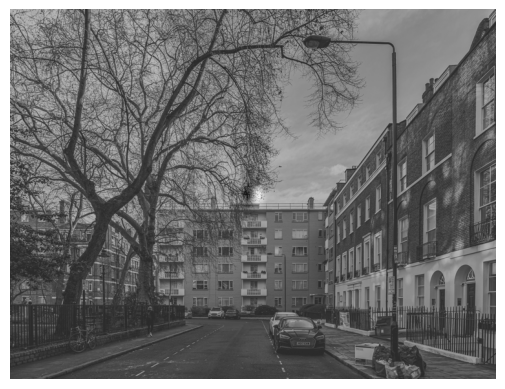

In [ ]:
def estimate_response(
    image_array: np.ndarray, 
    gabor: np.ndarray, 
    neuron_center: tuple,
    ax: plt.Axes = None,
    ) -> float:
    y_center, x_center = neuron_center

    # Create a zero-padded array of the expected neuron size
    neuron_img_arr = np.zeros((gabor.shape[0], gabor.shape[0]), dtype=image_array.dtype)
    
    # Define the expected boundaries in the image
    y_start_img = max(0, y_center - gabor.shape[0] // 2)
    y_end_img   = min(image_array.shape[0], y_center + gabor.shape[0] // 2)
    x_start_img = max(0, x_center - gabor.shape[1] // 2)
    x_end_img   = min(image_array.shape[1], x_center + gabor.shape[1] // 2)
    
    # Calculate the corresponding indices in the zero-padded neuron image
    offset_y = y_start_img - (y_center - gabor.shape[0] // 2)
    offset_x = x_start_img - (x_center - gabor.shape[1] // 2)
    
    neuron_img_arr[offset_y:offset_y + (y_end_img - y_start_img),
                   offset_x:offset_x + (x_end_img - x_start_img)] = image_array[y_start_img:y_end_img,
                                                                               x_start_img:x_end_img]
    r_est = np.sum(gabor * neuron_img_arr)
    
    if ax is not None:
        # Create an overlay on the full image
        overlay = np.zeros_like(image_array)
        # Only update the region that overlaps with the image
        overlay[y_start_img:y_end_img, x_start_img:x_end_img] = gabor[offset_y:offset_y+(y_end_img - y_start_img),
                                                                      offset_x:offset_x+(x_end_img - x_start_img)]
        alpha = 0.5  # (0 = only image, 1 = only Gabor)
        overlayed_image = (1 - alpha) * image_array + alpha * overlay
        
        ax.imshow(overlayed_image, cmap="gray")
        ax.axis("off")
    return r_est

shifts = np.arange(32, 112, 16)
# print(shifts)

fig, axes = plt.subplots(len(shifts), 1)
for idx, shift in enumerate(shifts):
    neuron_center = (grating_array.shape[0] // 2, shift)
    r_est = estimate_response(grating_array, gabor, neuron_center, ax=axes[idx])
    print(f"Neuron center: {neuron_center}, Response: {r_est}")

[32 48 64 80 96]
Neuron center: (64, np.int64(32)), Response: -499.41430122725717
Neuron center: (64, np.int64(48)), Response: -48.20002936724218
Neuron center: (64, np.int64(64)), Response: 499.27685992085827
Neuron center: (64, np.int64(80)), Response: 49.9252295485058
Neuron center: (64, np.int64(96)), Response: -483.10523209312265


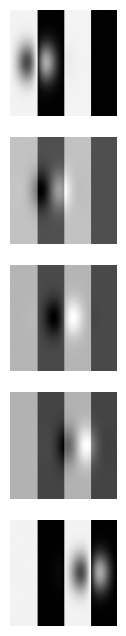

In [ ]:
neuron_center = (image_array.shape[0] // 2, image_array.shape[1] // 2)
fig, ax = plt.subplots()
r_est = estimate_response(image_array, gabor, neuron_center, ax=ax)
r_est

## Encoding

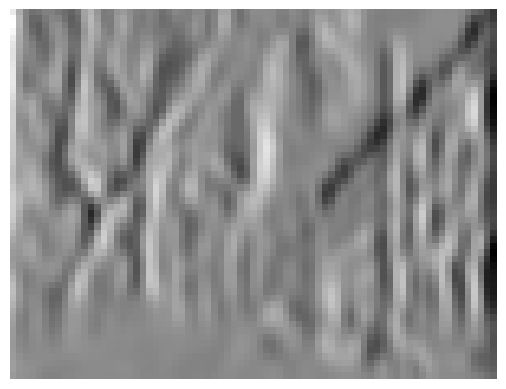

In [65]:
def encode(
    image_array: np.ndarray, 
    gabor: np.ndarray, 
    num_neurons: tuple[int, int],
    ax: plt.Axes = None,
    ) -> np.ndarray:

    n, m = num_neurons
    r_est_array = np.ones((n, m), dtype=np.float32)
    for i in range(1,n+1):
        for j in range(1,m+1):
            x_center = image_array.shape[0] // n * i
            y_center = image_array.shape[1] // m * j
            neuron_center = (x_center, y_center)
            r_est_array[i-1, j-1] = estimate_response(
                image_array, gabor, neuron_center, ax=ax
            )
    r_est_array.max(), r_est_array.min()

    r_est_array /= max(r_est_array.max(), abs(r_est_array.min()))
    
    if ax is not None:
        ax.imshow(r_est_array, cmap="gray")
        ax.axis("off")
    return r_est_array

n = image_array.shape[0] // 10
m = image_array.shape[1] // 10
fig, ax = plt.subplots()
r_est_array = encode(image_array, gabor, (n, m), ax=ax)

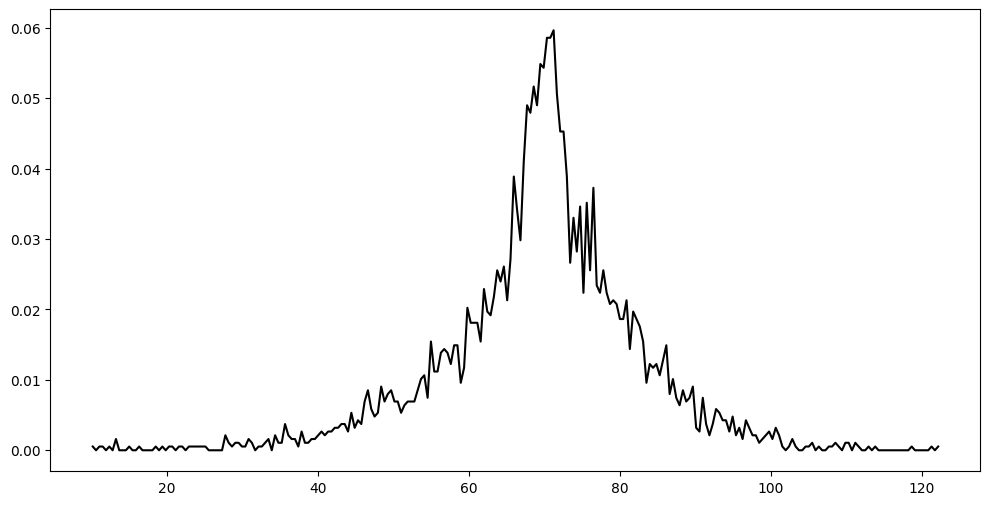

In [83]:
def line_hist(a: np.ndarray, bins: int, plot: bool = False) -> tuple:
    hist, bin_edges = np.histogram(a.flatten(), bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(bin_centers, hist, color='black')
    return hist, bin_centers

r_est_array_scaled = (r_est_array + 2) * 60 - 50
r_est_array_hist, r_est_array_bin_centers = line_hist(r_est_array, bins=256, plot=False)
r_est_array_scaled_hist, r_est_array_scaled_bin_centers = line_hist(r_est_array_scaled, bins=256, plot=False)

# # Original r_est values
# plt.figure(figsize=(12, 6))
# plt.plot(r_est_array_bin_centers, r_est_array_hist, color='black', label='Original')
# plt.savefig("figures/r_est_histogram.svg", transparent=True, bbox_inches='tight')

plt.figure(figsize=(12, 6))
plt.plot(r_est_array_scaled_bin_centers, r_est_array_scaled_hist, color='black', label='Scaled')
plt.savefig("figures/r_est_scaled_histogram.svg", transparent=True, bbox_inches='tight')

In [79]:
def homogeneous_spike_generator(
    r: float,
    T: float = 1,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
    rng: np.random.Generator = np.random.default_rng(),
) -> np.ndarray:
    interspike_intervals = rng.exponential(scale=1/r, size=int(r * T * 2))
    spike_times = np.cumsum(interspike_intervals)
    spike_times = spike_times[spike_times < T]

    valid_spike_times = []
    i = 0
    while i < len(spike_times):
        current_time = spike_times[i]
        valid_spike_times.append(current_time)

        ref_period = abs_ref + rng.exponential(scale=rel_ref_mean)
        i += 1
        while i < len(spike_times) and spike_times[i] < current_time + ref_period:
            i += 1

    return np.array(valid_spike_times)

rng = np.random.default_rng()
_spikes = homogeneous_spike_generator(60, T=1, abs_ref=0.001, rel_ref_mean=0.01, rng=rng)
# plt.figure(figsize=(12, 6))
# plt.eventplot(_spikes)
# plt.title("Spike Times")
# plt.xlabel("Time (s)")
# plt.ylabel("Spike")
# plt.grid(True)
# plt.show()

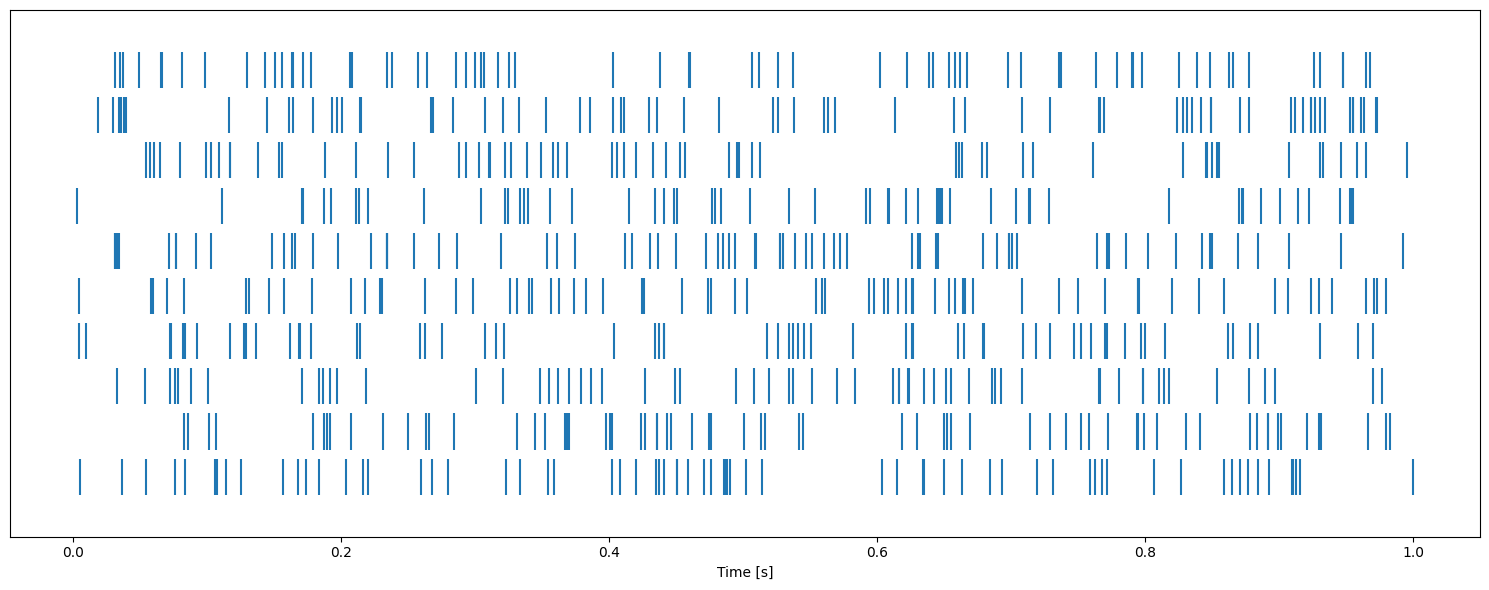

In [82]:
def model_response_spikes(
    r_est_array: np.ndarray,
    T: float = 1,
    abs_ref: float = 0.001,
    rel_ref_mean: float = 0.01,
    rng: np.random.Generator = np.random.default_rng(),
) -> list[list[np.ndarray]]:
    r_est_array_scaled = (r_est_array + 2) * 60 - 50
    population_spikes = []
    for row in r_est_array_scaled:
        response_row = []
        for r in row:
            spikes = homogeneous_spike_generator(r, T=T, abs_ref=abs_ref, rel_ref_mean=rel_ref_mean, rng=rng)
            response_row.append(spikes)
        population_spikes.append(response_row)
    return population_spikes

T = 10  # [s]
population_spikes = model_response_spikes(r_est_array, T=T, abs_ref=0, rel_ref_mean=0, rng=rng)

n_rows = len(population_spikes)
n_cols = len(population_spikes[0])

# Plotting the spike trains for the first 10 neurons in the center column
center_col_idx = n_cols // 2
center_column_spikes = [population_spikes[i][center_col_idx] for i in range(n_rows)]
fig, ax = plt.subplots(figsize=(15, 6))
ax.eventplot([spikes[spikes <= 1.0] for spikes in center_column_spikes[:10]], orientation='horizontal', linelengths=0.8)
ax.set_xlabel("Time [s]")
ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

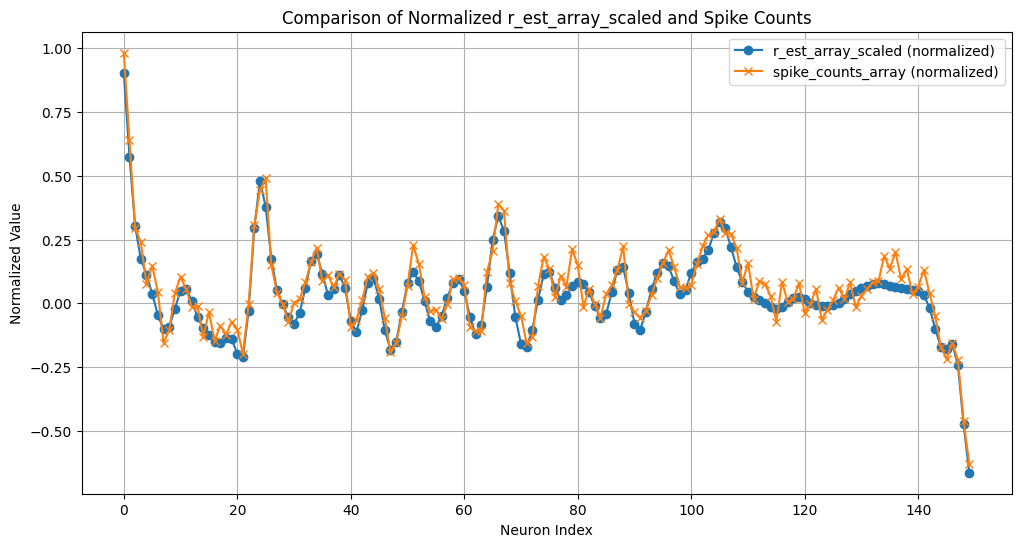

In [108]:
def compute_population_response(population_spikes):
    n_rows = len(population_spikes)
    n_cols = len(population_spikes[0])
    
    population_spike_counts = np.zeros((n_rows, n_cols), dtype=int)
    
    for i in range(n_rows):
        for j in range(n_cols):
            population_spike_counts[i, j] = len(population_spikes[i][j])
    
    population_response_norm = (2 * (population_spike_counts - np.min(population_spike_counts)) / 
                                (np.max(population_spike_counts) - np.min(population_spike_counts)) ) - 1
    return population_response_norm

r_est_norm = (2 * (r_est_array_scaled - np.min(r_est_array_scaled)) / 
              (np.max(r_est_array_scaled) - np.min(r_est_array_scaled)) ) - 1

population_response_norm = compute_population_response(population_spikes)
# Plot
plt.figure(figsize=(12, 6))
plt.plot(r_est_norm[1, :], label='r_est_array_scaled (normalized)', marker='o')
plt.plot(population_response_norm[1, :], label='spike_counts_array (normalized)', marker='x')
plt.title("Comparison of Normalized r_est_array_scaled and Spike Counts")
plt.xlabel("Neuron Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()


## Decoding

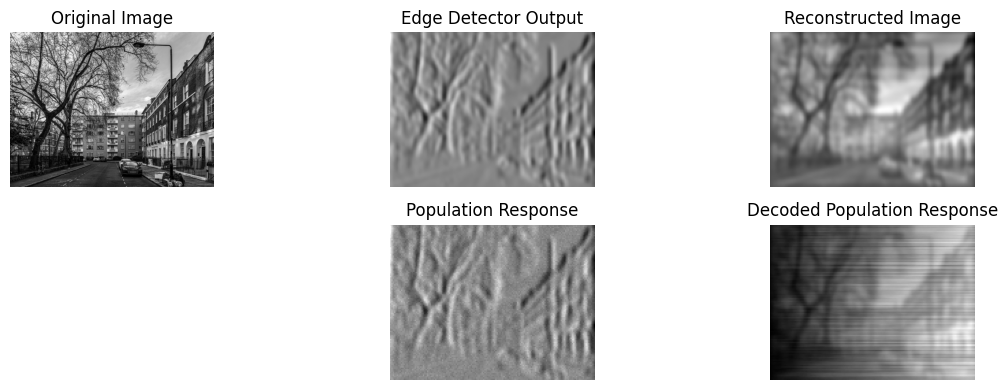

(np.float32(-1.0),
 np.float32(0.9219679),
 np.float32(-1.6409639),
 np.float32(3.888905))

In [109]:
def decode(
    neural_resp_arr: np.ndarray,
    ) -> np.ndarray:
    decoded = np.cumsum(neural_resp_arr, axis=1)
    return decoded

# r_est_array = population_response_norm
# decoded = np.cumsum(r_est_array.transpose(), axis=0)
decoded_r_est_array = decode(r_est_array)
decoded_population_response = decode(population_response_norm)

# Plot the images for comparison
plt.figure(figsize=(12, 4))
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Edge Detector Output")
plt.imshow(r_est_array, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(decoded_r_est_array, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Population Response")
plt.imshow(population_response_norm, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Decoded Population Response")
plt.imshow(decoded_population_response, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
r_est_array.min(), r_est_array.max(), decoded_r_est_array.min(), decoded_r_est_array.max()

## Multiple Populations

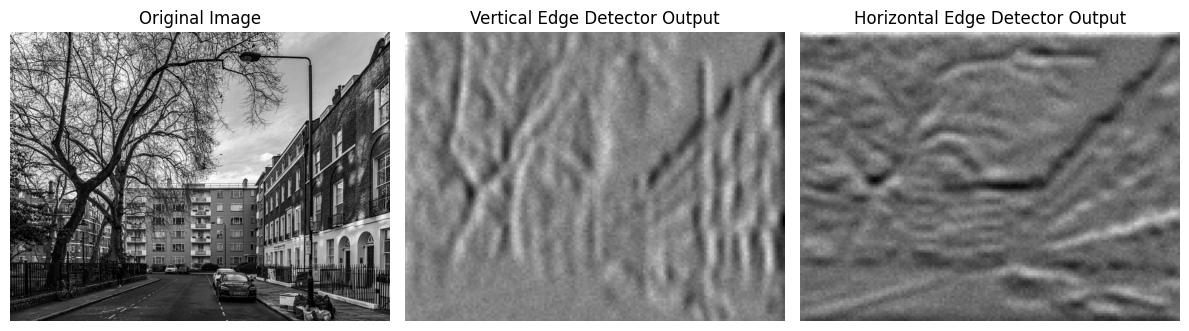

In [110]:
# Define Gabor filters for vertical and horizontal edge detection
vertical_orientation = np.pi           # Vertical edge detector (sensitive to vertical edges)
horizontal_orientation = -np.pi / 2   # Horizontal edge detector (sensitive to horizontal edges)

# Create two Gabor filters with different orientations
gabor_vertical = gabor_function(X, Y, wavelength, vertical_orientation, phase, sigma_x, sigma_y)
gabor_horizontal = gabor_function(X, Y, wavelength, horizontal_orientation, phase, sigma_x, sigma_y)

# Encode the image using each filter
r_est_array_vertical = encode(image_array, gabor_vertical, (n, m), plot=False)
r_est_array_horizontal = encode(image_array, gabor_horizontal, (n, m), plot=False)

# Generate spike trains
population_spikes_vertical = model_response_spikes(r_est_array_vertical, T=T, abs_ref=0, rel_ref_mean=0, rng=rng)
population_spikes_horizontal = model_response_spikes(r_est_array_horizontal, T=T, abs_ref=0, rel_ref_mean=0, rng=rng)

# Compute population responses
population_response_norm_vertical = compute_population_response(population_spikes_vertical)
population_response_norm_horizontal = compute_population_response(population_spikes_horizontal)

# population_response_norm_vertical = r_est_array_vertical
# population_response_norm_horizontal = r_est_array_horizontal

# Plot the images for comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Vertical Edge Detector Output")
plt.imshow(population_response_norm_vertical, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Horizontal Edge Detector Output")
plt.imshow(population_response_norm_horizontal, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

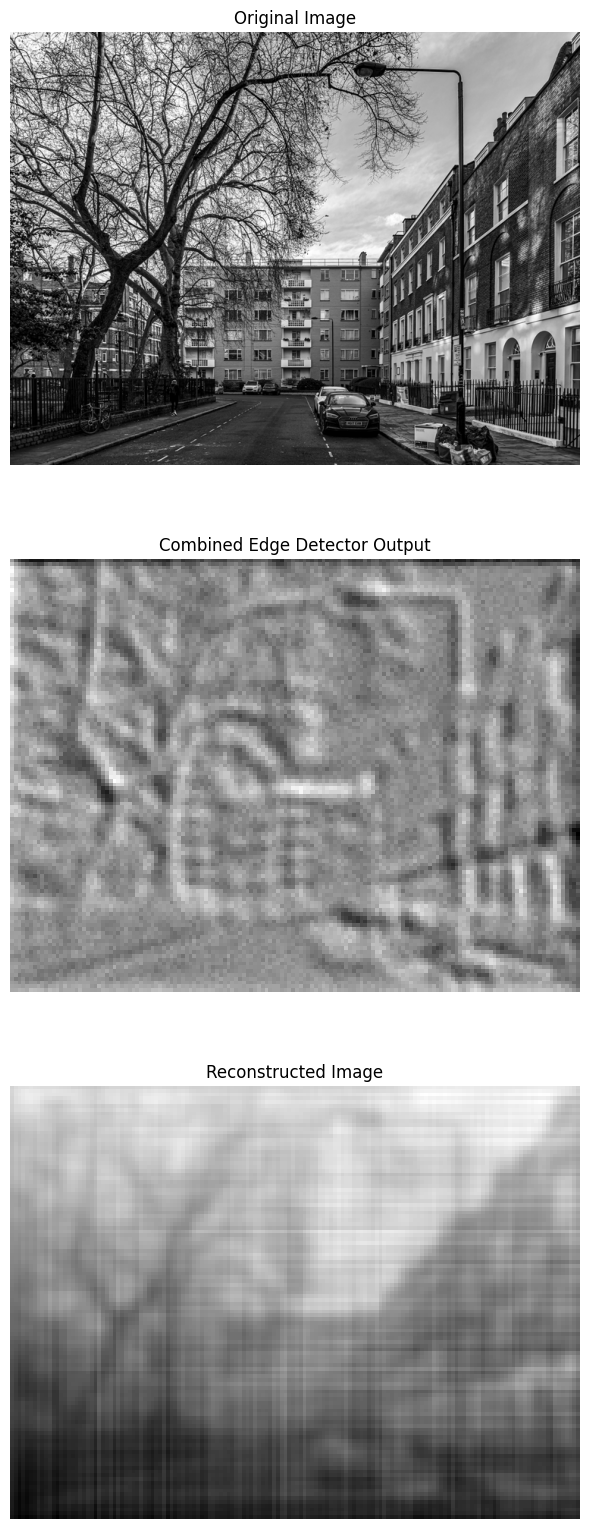

In [111]:
def decode_edges(population_response_vertical: np.ndarray, population_response_horizontal: np.ndarray) -> np.ndarray:
    # Integrate the vertical edge responses along the horizontal direction (axis=1)
    # This approximates reconstructing the image by integrating the horizontal gradient.
    recon_from_vertical = np.cumsum(population_response_vertical, axis=1)
    
    # Integrate the horizontal edge responses along the vertical direction (axis=0)
    # This approximates reconstructing the image by integrating the vertical gradient.
    recon_from_horizontal = np.cumsum(population_response_horizontal, axis=0)
    
    # Combine the two integrated images.
    # A simple approach is to average them, though other weighted combinations might be considered.
    reconstructed = (recon_from_vertical + recon_from_horizontal) / 2
    
    return reconstructed

decoded_population_response = decode_edges(population_response_norm_vertical, population_response_norm_horizontal)

plt.figure(figsize=(6, 16))
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.title("Combined Edge Detector Output")
# For visualization
combined_response = (population_response_norm_vertical - population_response_norm_horizontal) / 2
plt.imshow(combined_response, cmap='gray')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.title("Reconstructed Image")
plt.imshow(decoded_population_response, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


multiscale and multi orientation in an iterative manner such that it uses large neurons at few orientations then using information from this encoded information, encode more detailed information. e.g. if the standard deviation of responses from large neurons next to each other 

## Analysis

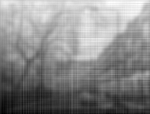

In [ ]:
def normalize_to_255(image: np.ndarray) -> np.ndarray:
    # Ensure the image is a float for accurate normalization
    image = image.astype(np.float32)
    
    # Normalize to range 0-1
    image_min = image.min()
    image_max = image.max()
    if image_max - image_min == 0:
        return np.zeros_like(image, dtype=np.uint8)
    
    normalized = (image - image_min) / (image_max - image_min)
    
    # Scale to range 0-255 and convert to uint8
    normalized_255 = (normalized * 255).astype(np.uint8)
    
    return normalized_255
decoded_normalized = normalize_to_255(decoded_population_response)

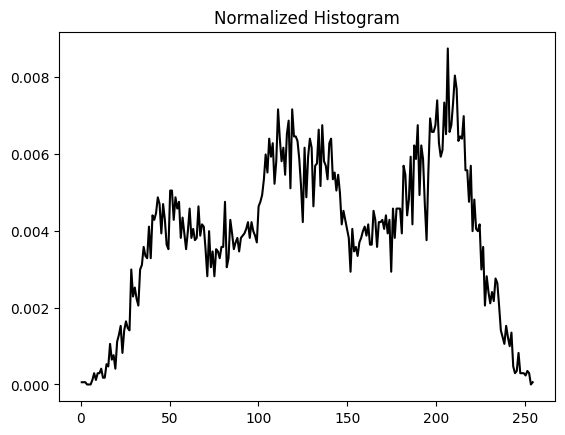

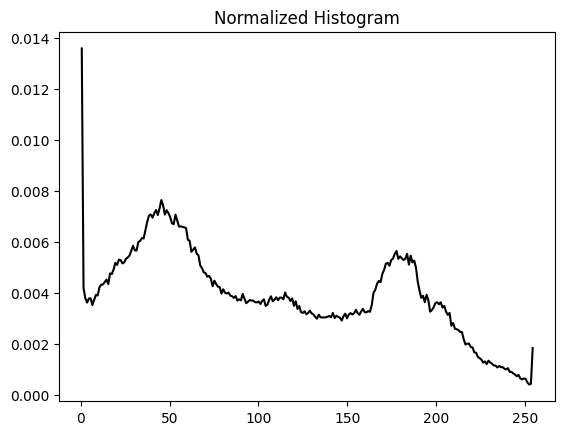

Relative Entropy: inf


In [ ]:
decoded_hist, decoded_bin_centers = line_hist(normalize_to_255(decoded_population_response), bins=256, plot=True)
image_hist, image_bin_centers = line_hist(normalize_to_255(image_array), bins=256, plot=True)

rel_entropy = np.sum(rel_entr(image_hist, decoded_hist))  # rel_entr = P * log(P/Q)
print(f"Relative Entropy: {rel_entropy}")

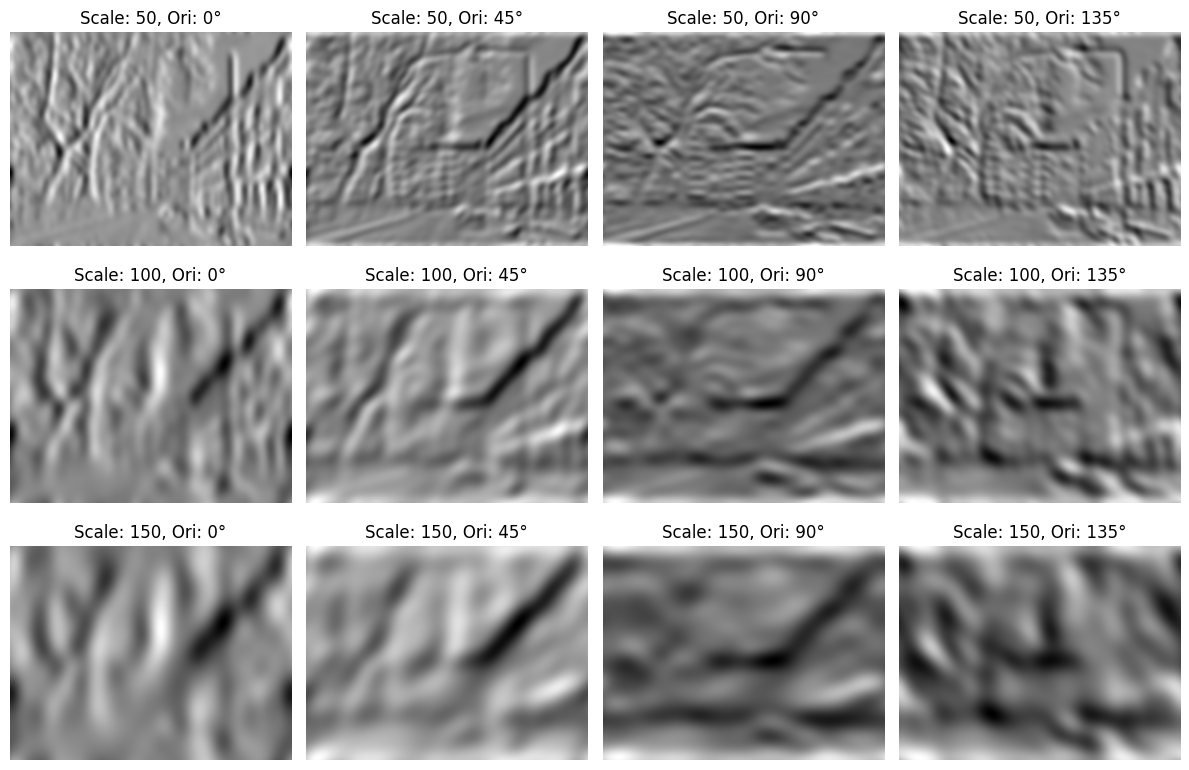

In [ ]:
def create_gabor_filter(wavelength, orientation, phase, sigma_x, sigma_y):
    # Define the filter size to be proportional to the wavelength (to capture enough cycles)
    filter_size = int(2 * wavelength)
    x = np.linspace(-wavelength, wavelength, filter_size)
    y = np.linspace(-wavelength, wavelength, filter_size)
    X, Y = np.meshgrid(x, y)
    return gabor_function(X, Y, wavelength, orientation, phase, sigma_x, sigma_y)

orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°
wavelengths = [50, 100, 150]  # Example wavelengths for different scales
phase = np.pi/2  # Phase offset (you can experiment with this)

# Create and apply the filter bank
responses = {}  # Dictionary to store responses for each (scale, orientation)
for wavelength in wavelengths:
    # Define sigma values relative to wavelength (adjust as needed)
    sigma_x = wavelength / 5
    sigma_y = wavelength / 5
    for orientation in orientations:
        # Create the Gabor filter for this scale and orientation
        gabor_filter = create_gabor_filter(wavelength, orientation, phase, sigma_x, sigma_y)
        # Convolve the filter with the image (using 'same' mode to keep dimensions)
        response = convolve2d(image_array, gabor_filter, mode='same', boundary='wrap')
        responses[(wavelength, orientation)] = response

fig, axs = plt.subplots(len(wavelengths), len(orientations), figsize=(12, 8))
for i, wavelength in enumerate(wavelengths):
    for j, orientation in enumerate(orientations):
        response = responses[(wavelength, orientation)]
        axs[i, j].imshow(response, cmap='gray')
        axs[i, j].set_title(f"wavelength: {wavelength}, $\\theta$: {np.degrees(orientation):.0f}°")
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()

